Training loss is:   11.341, CV loss is:   65.634 at step 5000

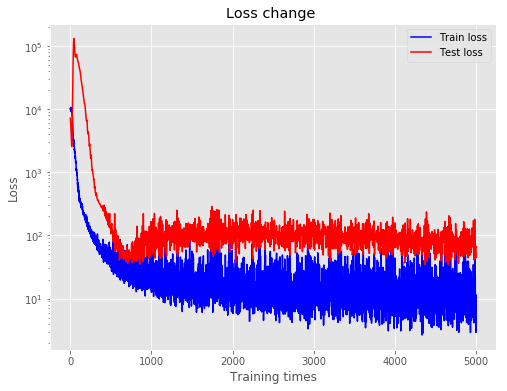

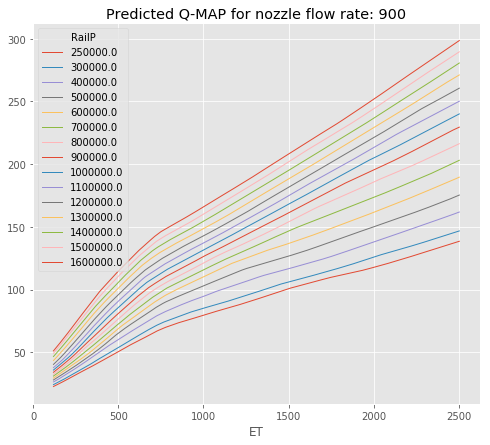

In [91]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cross_validation import train_test_split
def make_X(flow):
    '''生成预测的数据
    参数是nozzle flow
    以后会扩充到所有可输入参数
    '''
    tlf=pd.read_csv("Pred_CRIN.csv",index_col=0)
    tlf.drop(columns=["InjQ"],inplace=True)
    names=tlf.columns.values
    ETs=[e for e in range(120,2504,3)]
    RailP=[250000]+[p for p in range(300000,1700000,100000)]
    tf=pd.DataFrame()
    es=pd.Series(ETs)
    ps=pd.Series({"RailP":RailP})
    for p in RailP:
        ttf=pd.DataFrame(es,columns=["ET"])
        ttf['RailP']=p
        tf=tf.append(ttf,sort=False)
    tlf.drop(columns=["ET","RailP"],inplace=True)
    #print(names)
    tf=tlf.append(tf,sort=False)
    tf.fillna(method='ffill',inplace=True)
    tf.dropna(how='any',axis=0,inplace=True)
    tf = tf.reindex(columns=names)    
    tf['Nozzle Flow Rate_ cm3/30s@100bar']=flow
    
    return tf

tf.reset_default_graph()


af=pd.read_csv("CRIN.csv")
af.drop(columns=["Unnamed: 0","ID"],inplace=True)



X=af.iloc[:,:-1].values
y=[[e] for e in af.InjQ.values]




tf_x = tf.placeholder(tf.float32, [None,20], name="tf_x")     # 输入量 占位符 特征是多少维的，这里就定义多少维
tf_y = tf.placeholder(tf.float32, [None,1], name="tf_y")     # 输出量
isTraing=tf.placeholder(tf.bool, name="isTraing")
# neural network layers
#l1 = tf.layers.dense(tf_x,30,None)
l1 = tf.layers.batch_normalization(tf_x,training=isTraing) # 将输入量归一化（或者叫标准化）
l1 = tf.layers.dense(l1,128,tf.nn.relu) #添加一个隐藏层，并指定神经元个数以及激活函数
drop_out = tf.nn.dropout(l1, 0.4) # 去除一部分连接，防止过拟合
l1 = tf.layers.dense(l1,128,tf.nn.relu)

drop_out = tf.nn.dropout(l1, 0.4) # 去除一部分连接，防止过拟合
l1 = tf.layers.dense(l1,128,tf.nn.relu)
drop_out = tf.nn.dropout(l1, 0.4) # 去除一部分连接，防止过拟合
output = tf.layers.dense(l1, 1)                     # 输出层，仅有一个输出
#x_norm = tf.layers.batch_normalization(tf_x, training=False)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # 配合标准化必须的操作
#cross_entropy = -tf.reduce_sum(tf_y*tf.log(output))
#loss = tf.losses.mean_squared_error(tf_y, output)   # MSE==均方差作为误差函数
loss = tf.reduce_mean(tf.square(tf_y-output))
#eloss = tf.metrics.mean_squared_error(tf_y,output)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
#train_op = optimizer.minimize(loss)
def get_batch(raw_X,raw_y,size=100):
    '''
    从原始数据中随机挑出size=size个数据
    '''
    idx=np.random.choice(range(len(raw_X)),size,replace=False)
    X=[raw_X[x] for x in idx]
    y=[raw_y[x] for x in idx]
    return X,y

#train_X,test_X, train_y, test_y=train_test_split(X,y,test_size = 0.3)
#idd=list(range(20000))
test_X=X[:20000]
test_y=y[:20000]
train_X=X[20000:]
train_y=y[20000:]
#X_train,y_train=get_batch(train_X,train_y,size=1024)
with tf.control_dependencies(update_ops):
    #train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
    train_step = tf.train.AdamOptimizer(0.001).minimize(loss)
sess = tf.Session()                                 # 建立和Session的连接
sess.run(tf.global_variables_initializer())         # 初始化计算图中的变量



lo=[] # 保存所有的历史成本
Va=[]
for step in range(5000+1): # 迭代训练次数
    # train and net output    
    X_train,y_train=get_batch(train_X,train_y,size=1024) # 获取随机批次的数据，准备喂给tensorflow
    #print(X_train.shape)
    #print(y_train.shape)
    _, l, pred = sess.run([train_step, loss, output], feed_dict={tf_x: X_train, tf_y: y_train,isTraing:True})
    #sess.run(train_step, feed_dict={tf_x: X_train, tf_y: y_train})
    #sess.run(train_op, feed_dict={tf_x: X, tf_y: y})
    Val_loss=sess.run(loss,feed_dict={tf_x:test_X,tf_y:test_y,isTraing:False})

    
    lo.append(l)
    Va.append(Val_loss)
    
    #total_error = tf.reduce_sum(tf.square(tf.sub(tf_y, tf.reduce_mean(tf_y))))
    #R_squared = tf.sub(1, tf.div(unexplained_error, total_error))
    #r2_score(y_test,y_predict)
    if(np.isnan(l)):
        raise("NaN")
    print('\rTraining loss is:{0: 9.3f}, CV loss is:{1: 9.3f} at step {2}'.format( l ,Val_loss, step),end='')
    if(Val_loss<3):
        print('\nTraining stopped.\nTraining loss is:{0: 9.3f}, CV loss is:{1: 9.3f} at step {2}'.format( l ,Val_loss, step))
        break #Stop iteration   
#print("Validation Loss:",sess.run(loss,feed_dict={tf_x:test_X,tf_y:test_y,isTraing:False}))
saver=tf.train.Saver()
saver.save(sess,'./testsaver.cpkt')
plt.style.use('ggplot') # plot style 使用 ggplot
plt.figure(figsize=(8, 6))
tp=plt.plot(range(len(lo)),lo,c='b',label="Train Loss") # 画出成本随训练次数的变化
ts=plt.plot(range(len(lo)),Va,c='r',label="Test loss") # 画出测试随训练次数的变化
plt.title("Loss change ")
plt.xlabel("Training times")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend(["Train loss",'Test loss'],loc='best')
plt.show()
flows=[900]
plt.figure(figsize=(8, 7*len(flows)))

#output_pred = sess.run(output,{tf_x:x_pred})

for i in range(len(flows)):    # 预测并画图
    ax = plt.subplot( len(flows),1,i+1)
    #plt.setp(ax)
    #plt.title("Nozzle:%d" % flows[i])
    X_new=make_X(flows[i])
    y_pred = sess.run(output,{tf_x:X_new,isTraing:False})
    #y_pred=model.predict(X_new.values)
    X_new['InjQ']=y_pred
    #X_new.loc[X_new.InjQ<0,'InjQ']=0
    pF=X_new.loc[:,["ET","RailP","InjQ"]]
    ff=pd.pivot_table(pF,index='ET',columns='RailP')
    
    ff.columns=ff.columns.droplevel()
    ff.plot(ax=ax,linewidth=1,
            title="Predicted Q-MAP for nozzle flow rate: {}".format(flows[i]))


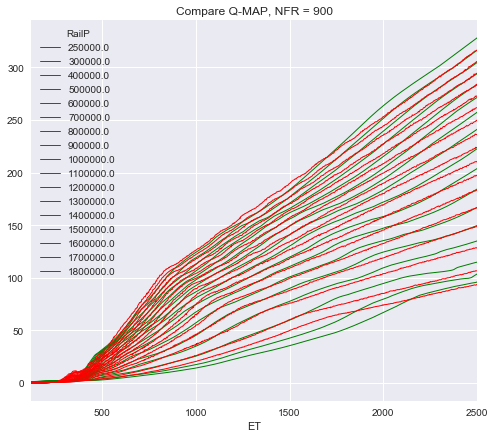

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tlf=pd.read_csv("Pred_CRIN.csv",index_col=0)
def make_X(row):
    '''生成预测的数据
    参数是nozzle flow
    以后会扩充到所有可输入参数
    '''
    tlf=row
    tlf.drop(labels=["InjQ"],axis=1,inplace=True)
    names=tlf.columns.values
    ETs=[e for e in range(121,2504,3)]
    RailP=[250000]+[p for p in range(300000,1900000,100000)]
    tf=pd.DataFrame()
    es=pd.Series(ETs)
    ps=pd.Series({"RailP":RailP})
    for p in RailP:
        ttf=pd.DataFrame(es,columns=["ET"])
        ttf['RailP']=p
        tf=tf.append(ttf)
    tlf.drop(labels=["ET","RailP"],axis=1,inplace=True)
    #print(names)
    tf=tlf.append(tf)
    tf.fillna(method='ffill',inplace=True)
    tf.dropna(how='any',axis=0,inplace=True)
    tf = tf.reindex(columns=names)    
    #tf['Nozzle Flow Rate_ cm3/30s@100bar']=flow
    
    return tf
d=[]
plt.style.use('seaborn')
for index, row in tlf.iterrows():
    #print(make_X(pd.DataFrame(row)))
    a=pd.DataFrame(row)
    f=make_X(a.T)
plt.figure(figsize=(8, 7*tlf.shape[0]))
idx=0
plist=[250000.]+[p for p in range(300000,1900000,100000)]
#plist=[250000.]+[p for p in [400000,600000,800000,1200000,1600000,1800000]]
for i, row in tlf.iterrows():    # 预测并画图
    idx+=1
    ax = plt.subplot( tlf.shape[0],1,idx)
    #plt.setp(ax)
    #plt.title("Nozzle:%d" % flows[i])
    a=pd.DataFrame(row)
    #=make_X()
    X_new=make_X(a.T)
    #y_pred = sess.run(output,{tf_x:X_new,isTraing:False})
    y_pred=model.predict(X_new)
    X_new['InjQ']=y_pred
    flow=row['Nozzle Flow Rate_ cm3/30s@100bar']
    #X_new.loc[X_new.InjQ<0,'InjQ']=0
    pF=X_new.loc[:,["ET","RailP","InjQ"]]
    ff=pd.pivot_table(pF,index='ET',columns='RailP')
    
    ff.columns=ff.columns.droplevel()
    ff.to_csv("CRIN"+str(int(flow))+".csv")
    ff.loc[:,ff.columns.isin(plist)].plot(ax=ax,linewidth=1,
            title="Compare Q-MAP, NFR = {0:g}".format(flow),color='g')
    testdf=pd.read_csv("testdata_CRIN.csv",index_col=0)
    testdf.loc[:,testdf.columns.isin([str(int(y)) for y in plist])].plot(ax=ax,linewidth=1,color='r',legend=False)
    #plt.scatter(1499,y0,s = 50,color = 'r',lw= 2)#散列要标注的坐标点

In [5]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
def make_X(flow):
    '''生成预测的数据
    参数是nozzle flow
    以后会扩充到所有可输入参数
    '''
    tlf=pd.read_csv("Pred_CRIN.csv",index_col=0)
    tlf.drop(labels=["InjQ"],axis=1,inplace=True)
    names=tlf.columns.values
    ETs=[e for e in range(80,2501,3)]
    RailP=[250000]+[p for p in range(300000,1700000,100000)]
    tf=pd.DataFrame()
    es=pd.Series(ETs)
    ps=pd.Series({"RailP":RailP})
    for p in RailP:
        ttf=pd.DataFrame(es,columns=["ET"])
        ttf['RailP']=p
        tf=tf.append(ttf)
    tlf.drop(columns=["ET","RailP"],inplace=True)
    #print(names)
    tf=tlf.append(tf)
    tf.fillna(method='ffill',inplace=True)
    tf.dropna(how='any',axis=0,inplace=True)
    tf = tf.reindex(columns=names)    
    tf['Nozzle Flow Rate_ cm3/30s@100bar']=flow
    
    return tf

model = keras.models.Sequential([
    # Adds a densely-connected layer with 64 units to the model:
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    # Add another:
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
# Add another:
#model.add(keras.layers.Dense(64, activation='relu'))
# Add a softmax layer with 10 output units:
    keras.layers.Dense(1),
])
# Configure a model for mean-squared error regression.
model.compile(optimizer='nadam',
              loss='mse',       # mean squared error
              metrics=['mae'])  # mean absolute error
# Instantiates a toy dataset instance:


af=pd.read_csv("CRIN.csv")
af.drop(labels=["Unnamed: 0","ID"],axis=1,inplace=True)
X=af.iloc[:,:-1].values
y=af.InjQ.values
#data,val_data, labels, val_labels=train_test_split(X,y,test_size = 0.05)



callbacks = [
  # Interrupt training if `val_loss` stops improving for over 2 epochs
  keras.callbacks.EarlyStopping(patience=2, monitor='loss'),
  # Write TensorBoard logs to `./logs` directory
  #keras.callbacks.TensorBoard(log_dir='./logs')
]
# Don't forget to specify `steps_per_epoch` when calling `fit` on a dataset.
model.fit(X,y, 
          epochs=50,
          batch_size=400,
          verbose=2,
          #validation_data=(val_data,val_labels),
          callbacks=callbacks,
          #shuffle=False,
          )

'''
#output_pred = sess.run(output,{tf_x:x_pred})
flows=[900]
plt.figure(figsize=(8, 7*len(flows)))
for i in range(len(flows)):    # 预测并画图
    ax = plt.subplot( len(flows),1,i+1)
    #plt.setp(ax)
    #plt.title("Nozzle:%d" % flows[i])
    X_new=make_X(flows[i])
    y_pred = model.predict(X_new) #sess.run(output,{tf_x:X_new,isTraing:False})
    #y_pred=model.predict(X_new.values)
    X_new['InjQ']=y_pred
    #X_new.loc[X_new.InjQ<0,'InjQ']=0
    pF=X_new.loc[:,["ET","RailP","InjQ"]]
    ff=pd.pivot_table(pF,index='ET',columns='RailP')
    
    ff.columns=ff.columns.droplevel()
    ff.plot(ax=ax,linewidth=1,
            title="Predicted Q-MAP for nozzle flow rate: {}".format(flows[i]))
'''
print('done. Saving model to CRIN.h5')
model.save('CRIN.h5')
print('Done!')

Epoch 1/50
 - 16s - loss: 401.7543 - mean_absolute_error: 10.6739
Epoch 2/50
 - 15s - loss: 91.0335 - mean_absolute_error: 6.7568
Epoch 3/50
 - 15s - loss: 80.7378 - mean_absolute_error: 6.3569
Epoch 4/50
 - 15s - loss: 72.3106 - mean_absolute_error: 6.0173
Epoch 5/50
 - 16s - loss: 69.8660 - mean_absolute_error: 5.8908
Epoch 6/50
 - 14s - loss: 66.9638 - mean_absolute_error: 5.7890
Epoch 7/50
 - 14s - loss: 64.4658 - mean_absolute_error: 5.6831
Epoch 8/50
 - 17s - loss: 61.7587 - mean_absolute_error: 5.5692
Epoch 9/50
 - 17s - loss: 60.1448 - mean_absolute_error: 5.5034
Epoch 10/50
 - 15s - loss: 58.7561 - mean_absolute_error: 5.4318
Epoch 11/50
 - 18s - loss: 58.2492 - mean_absolute_error: 5.4133
Epoch 12/50
 - 21s - loss: 58.0533 - mean_absolute_error: 5.3954
Epoch 13/50
 - 16s - loss: 57.9541 - mean_absolute_error: 5.4055
Epoch 14/50
 - 15s - loss: 54.8837 - mean_absolute_error: 5.2551
Epoch 15/50
 - 15s - loss: 55.5367 - mean_absolute_error: 5.2865
Epoch 16/50
 - 14s - loss: 55.28

ImportError: `save_model` requires h5py.

C:\Users\taz3wx\AppData\Local\conda\conda\envs\myroot\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Tring to load model
Error happened when loading model. Abort


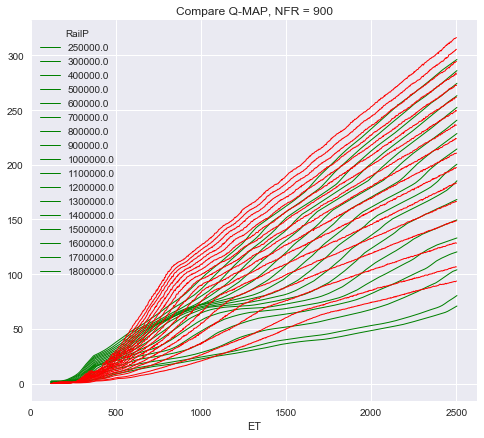

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tlf=pd.read_csv("Pred_CRIN.csv",index_col=0)
def make_X(row):
    '''生成预测的数据
    参数是nozzle flow
    以后会扩充到所有可输入参数
    '''
    tlf=row
    tlf.drop(labels=["InjQ"],axis=1,inplace=True)
    names=tlf.columns.values
    ETs=[e for e in range(121,2504,3)]
    RailP=[250000]+[p for p in range(300000,1900000,100000)]
    tf=pd.DataFrame()
    es=pd.Series(ETs)
    ps=pd.Series({"RailP":RailP})
    for p in RailP:
        ttf=pd.DataFrame(es,columns=["ET"])
        ttf['RailP']=p
        tf=tf.append(ttf)
    tlf.drop(labels=["ET","RailP"],axis=1,inplace=True)
    #print(names)
    tf=tlf.append(tf)
    tf.fillna(method='ffill',inplace=True)
    tf.dropna(how='any',axis=0,inplace=True)
    tf = tf.reindex(columns=names)    
    #tf['Nozzle Flow Rate_ cm3/30s@100bar']=flow
    
    return tf
d=[]
plt.style.use('seaborn')
for index, row in tlf.iterrows():
    #print(make_X(pd.DataFrame(row)))
    a=pd.DataFrame(row)
    f=make_X(a.T)
plt.figure(figsize=(8, 7*tlf.shape[0]))
idx=0
plist=[250000.]+[p for p in range(300000,1900000,100000)]
#plist=[250000.]+[p for p in [400000,600000,800000,1200000,1600000,1800000]]
print("Tring to load model")
try:
    model = keras.models.load_model('CRIN.h5')
    print("Success!")
except:
    print("Error happened when loading model. Abort")
    exit(-1)
#model.load_weights('./checkpoints/CRIN_good')
for i, row in tlf.iterrows():    # 预测并画图
    idx+=1
    ax = plt.subplot( tlf.shape[0],1,idx)
    #plt.setp(ax)
    #plt.title("Nozzle:%d" % flows[i])
    a=pd.DataFrame(row)
    #=make_X()
    X_new=make_X(a.T)
    #y_pred = sess.run(output,{tf_x:X_new,isTraing:False})
    y_pred=model.predict(X_new)
    X_new['InjQ']=y_pred
    flow=row['Nozzle Flow Rate_ cm3/30s@100bar']
    #X_new.loc[X_new.InjQ<0,'InjQ']=0
    pF=X_new.loc[:,["ET","RailP","InjQ"]]
    ff=pd.pivot_table(pF,index='ET',columns='RailP')
    
    ff.columns=ff.columns.droplevel()
    ff.to_csv("CRIN"+str(int(flow))+".csv")
    ff.loc[:,ff.columns.isin(plist)].plot(ax=ax,linewidth=1,
            title="Compare Q-MAP, NFR = {0:g}".format(flow),color='g')
    testdf=pd.read_csv("testdata_CRIN.csv",index_col=0)
    testdf.loc[:,testdf.columns.isin([str(int(y)) for y in plist])].plot(ax=ax,linewidth=1,color='r',legend=False)
    #plt.scatter(1499,y0,s = 50,color = 'r',lw= 2)#散列要标注的坐标点